In [1]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ignore chained assignment warning in pandas
pd.set_option('mode.chained_assignment', None)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF', '#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300


# import data

In [3]:
# read in data 

pro_cv_df = pd.read_csv('../../data/4-fitting/pro/cv_data.csv')
syn_cv_df = pd.read_csv('../../data/4-fitting/syn/cv_data.csv')

# combine and sort dataframes
pro_cv_df['genus'] = 'pro'
syn_cv_df['genus'] = 'syn'
combo_df = pd.concat([pro_cv_df, syn_cv_df])
combo_df = combo_df.sort_values(['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair'])

# limit dataset to values of interest
df = combo_df
# df = combo_df[combo_df['bootstrap_id'].isin(np.arange(4))]
# df = df[df['rank'].isin([1, 10, 20, 25, 30, 35, 40, 50, 60, 70])]
# df = df[df['rank'].isin([1, 10, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 50, 60, 70])]
# df = df[df['lambda'].isin([0, 0.01, 0.1, 1., 10., 100.])]

# look at minimums
for genus in ['pro', 'syn']:
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
    print(genus)
    print(results_df.groupby(
        ['rank', 'lambda']
    )[['relative_sse', 'fms_cv', 'css_cv_factor0', 'mean_gene_sparsity']].mean().sort_values(
        'relative_sse', ascending=True
    ).head(10))


pro
             relative_sse    fms_cv  css_cv_factor0  mean_gene_sparsity
rank lambda                                                            
60   1.0         0.701534  0.453293        0.559215          765.227778
40   1.0         0.702262  0.542285        0.645509          975.000000
35   1.0         0.703142  0.574024        0.690528         1048.733333
50   1.0         0.704326  0.467474        0.580905          861.953333
70   1.0         0.704960  0.434197        0.545175          690.647619
33   1.0         0.705252  0.559315        0.669955         1070.414141
30   2.0         0.705858  0.566736        0.682514          579.502222
34   1.0         0.706132  0.583999        0.697851         1081.303922
32   1.0         0.706859  0.561456        0.678175         1101.135417
31   1.0         0.707287  0.573597        0.685261         1124.322581
syn
             relative_sse    fms_cv  css_cv_factor0  mean_gene_sparsity
rank lambda                                             

In [4]:
df[
    (df['replicate_pair'] == 'A, A') &
    (df['genus'] == 'syn')
].groupby(['rank', 'lambda'])['bootstrap_id'].count().value_counts()

10    144
4     100
2      28
1       6
Name: bootstrap_id, dtype: int64

# rank & lambda plots

pro


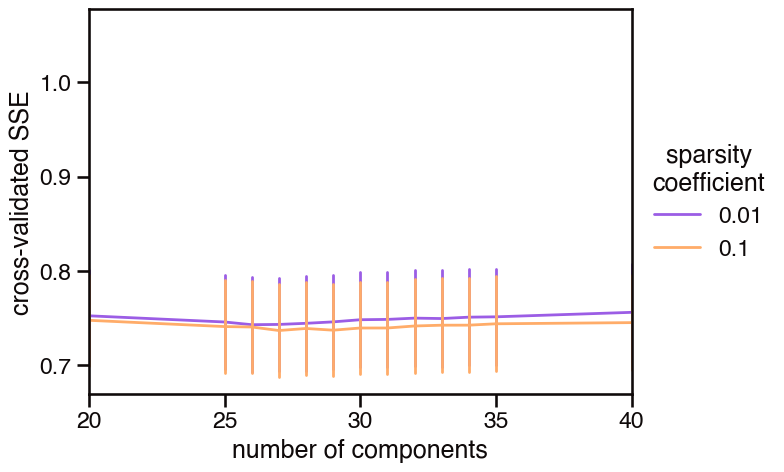

syn


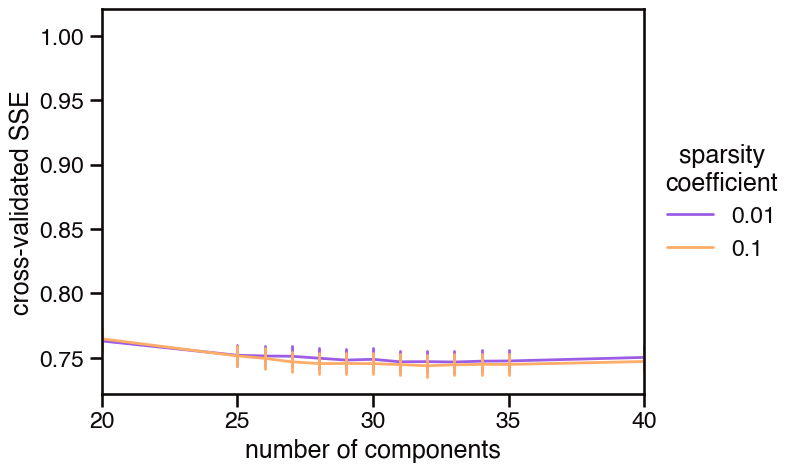

In [34]:
# look at relative_sse vs rank

plot_ranks = {
    'pro': [1, 10, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 50, 60, 70], 
#     'pro': [1, 10, 20, 25, 30, 35, 40, 50, 60, 70], 
    'syn': [1, 10, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 50, 60, 70], 
#     'syn': [1, 10, 20, 25, 30, 35, 40, 50, 60, 70], 
}
# plot_ranks = [1, 10, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 50, 60, 70]
# plot_lambdas = [0, 0.01, 0.1, 1., 10., 100.]
plot_lambdas = [0.01, 0.1]
plot_bootstraps = np.arange(10)

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['bootstrap_id'].isin(plot_bootstraps)]
    results_df = results_df[results_df['rank'].isin(plot_ranks[genus])]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, lamb in enumerate(plot_lambdas):
        data_df = results_df[results_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=lamb
    );
    plt.xlim([20, 40])
    plt.xlabel('number of components')
    plt.ylabel('cross-validated SSE')
    plt.legend(title='\t sparsity\ncoefficient', alignment='center', loc='center left', bbox_to_anchor=(1, .5));
    plt.savefig('{}-sse-v-rank.png'.format(genus), bbox_inches='tight')
    plt.show()


In [49]:
# pick optimal rank, including only sparsity coefficients that exhibit a minimum

# look at minimums
for genus in ['pro', 'syn']:
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
    # only include sparsity coefficients with clear minimums
    results_df = results_df[results_df['lambda'].isin([.01, 0.1])]
    results_df = results_df[results_df['rank'].isin([1, 10, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 40, 50, 60, 70])]
    
    # show results
    print(genus)
    print(results_df.groupby(
        ['rank', 'lambda']
    )[['relative_sse', 'fms_cv', 'css_cv_factor0', 'mean_gene_sparsity']].mean().sort_values(
        'relative_sse', ascending=True
    ).head(10))


pro
             relative_sse    fms_cv  css_cv_factor0  mean_gene_sparsity
rank lambda                                                            
27   0.1         0.736716  0.540876        0.683380         3079.456790
29   0.1         0.737067  0.537397        0.664703         3006.586207
28   0.1         0.738880  0.556165        0.697535         3027.011905
30   0.1         0.739385  0.560291        0.694389         2933.022222
31   0.1         0.739402  0.554397        0.677781         2909.225806
26   0.1         0.740447  0.489375        0.630004         3103.743590
25   0.1         0.740895  0.517183        0.652955         3113.253333
32   0.1         0.741517  0.489665        0.626962         2928.416667
33   0.1         0.742358  0.515707        0.642485         2878.020202
34   0.1         0.742394  0.505813        0.632416         2864.088235
syn
             relative_sse    fms_cv  css_cv_factor0  mean_gene_sparsity
rank lambda                                             

pro


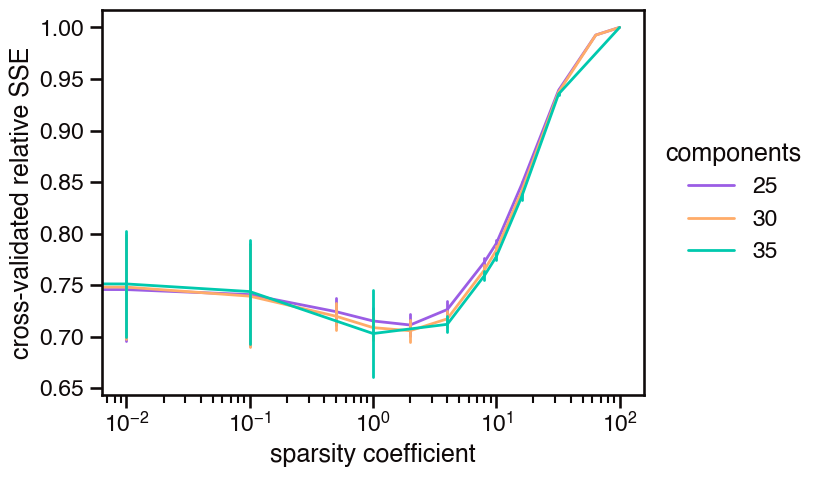

syn


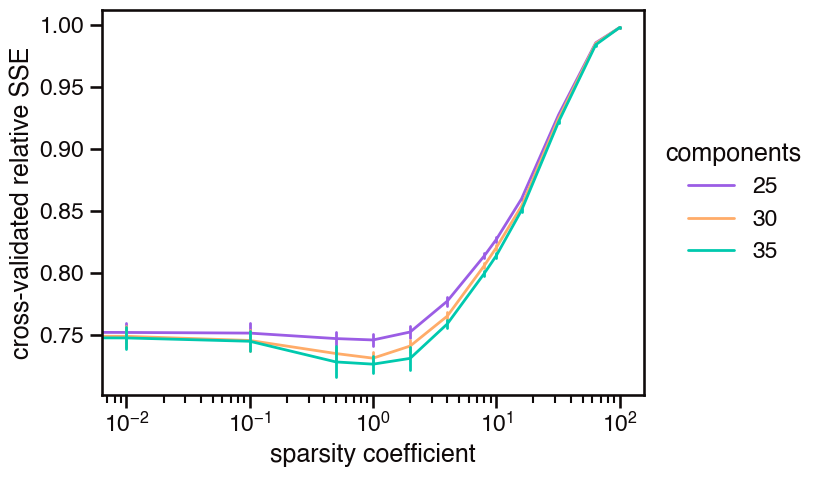

In [13]:
# look at relative_sse vs lambda

plot_ranks = {
    'pro': [25, 30, 35], 
    'syn': [25, 30, 35], 
}
plot_lambdas = [0, 0.01, 0.1, 0.5, 1., 2., 4., 8., 10., 16., 32., 64., 100.]
# plot_lambdas = np.arange(4, 32, 2)
plot_bootstraps = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['bootstrap_id'].isin(plot_bootstraps)]
    results_df = results_df[results_df['lambda'].isin(plot_lambdas)]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(plot_ranks[genus]):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
#         sns.scatterplot(
#             x='lambda', 
#             y='relative_sse', 
#             style='replicate_pair',
#             alpha=0.2, 
#             color=sns.color_palette()[i], 
#             data=data_df, 
#             ax=axis, 
#             legend=False
#         );
    plt.xscale('log', base=10);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('cross-validated relative SSE')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig('{}-sse-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


pro


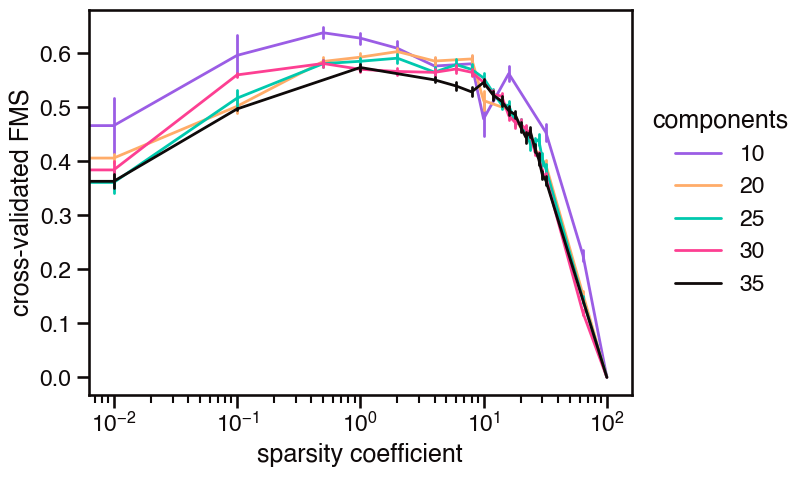

syn


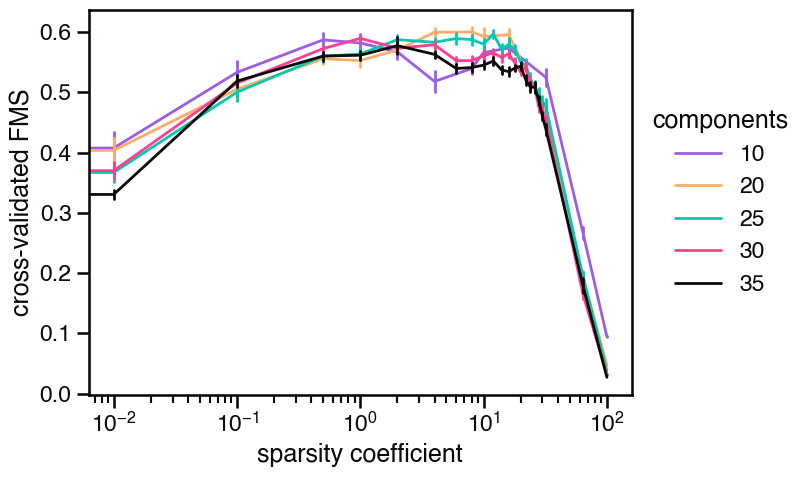

In [30]:
# look at fms vs lambda

plot_ranks = {
#     'pro': [25, 30, 35], 
    'pro': [10, 20, 25, 30, 35], 
#     'syn': [25, 30, 35], 
    'syn': [10, 20, 25, 30, 35], 
}
plot_lambdas = [0, 0.01, 0.1, 0.5, 1., 2., 4., 6., 8., 10., 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 64, 100]
# plot_lambdas = [0.1, 0.5, 1., 2.] + np.arange(4, 32, 2).tolist()
plot_bootstraps = np.arange(10)

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['bootstrap_id'].isin(plot_bootstraps)]
    results_df = results_df[results_df['lambda'].isin(plot_lambdas)]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(plot_ranks[genus]):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='fms_cv', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
#         sns.scatterplot(
#             x='lambda', 
#             y='fms_cv', 
#             style='replicate_pair',
#             color=sns.color_palette()[i], 
#             alpha=0.2, 
#             data=data_df, 
#             ax=axis, 
#             legend=False
#         );
    plt.xscale('log', base=10);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('cross-validated FMS')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig('{}-fms-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


pro


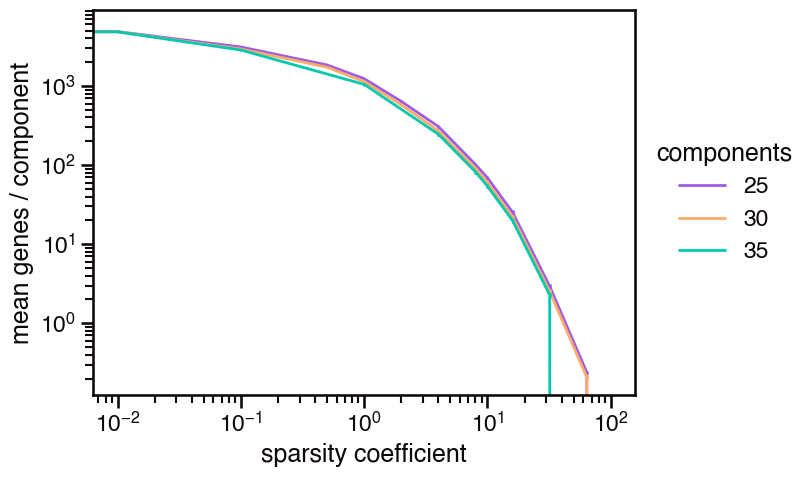

syn


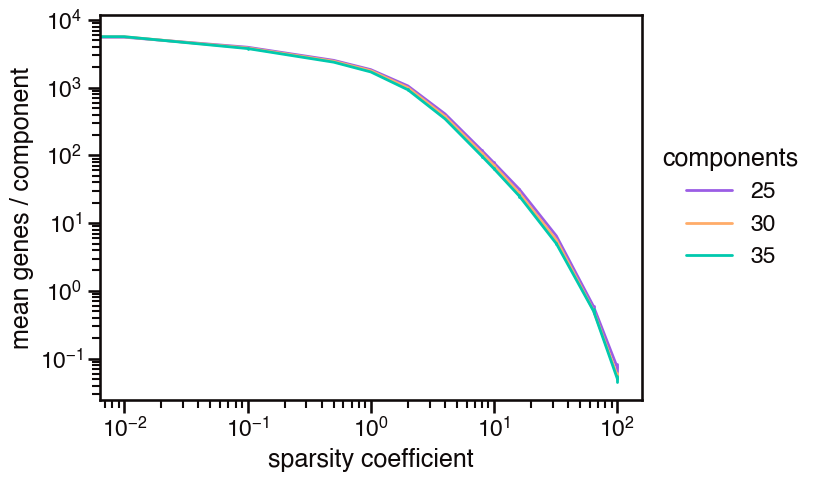

In [29]:
# look at mean_gene_sparsity vs lambda

plot_ranks = {
    'pro': [25, 30, 35], 
    'syn': [25, 30, 35], 
}
plot_lambdas = [0, 0.01, 0.1, 0.5, 1., 2., 4., 8., 10., 16., 32., 64., 100.]
plot_bootstraps = np.arange(10)

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['bootstrap_id'].isin(plot_bootstraps)]
    results_df = results_df[results_df['lambda'].isin(plot_lambdas)]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
    
    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(plot_ranks[genus]):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='mean_gene_sparsity', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
    #     sns.scatterplot(
    #         x='lambda', 
    #         y='mean_gene_sparsity', 
    #         style='replicate_pair',
    #         alpha=0.2, 
    #         color=sns.color_palette()[i], 
    #         data=data_df, 
    #         ax=axis, 
    #         legend=False
    #     );
    plt.xscale('log', base=10);
    plt.yscale('log', base=10)
    plt.xlabel('sparsity coefficient')
    plt.ylabel('mean genes / component')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig('{}-genes-per-component-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


# other figures

pro


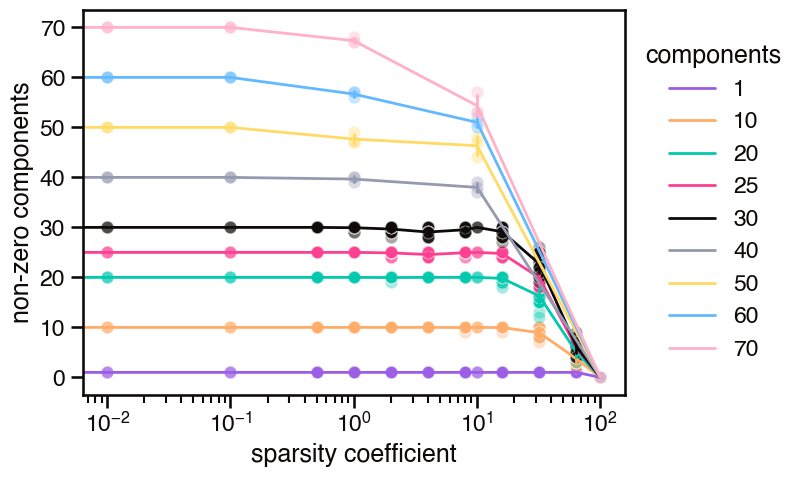

syn


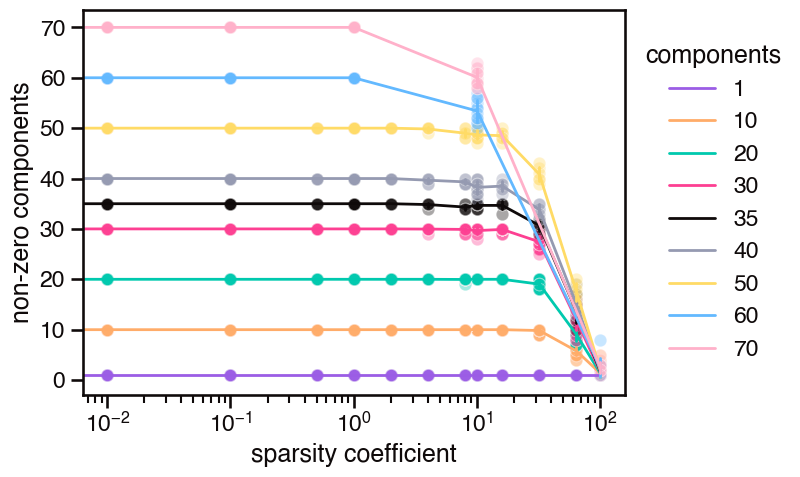

In [45]:
# look at n_components vs lambda

plot_ranks = {
    'pro': [1, 10, 20, 25, 30, 40, 50, 60, 70], 
    'syn': [1, 10, 20, 30, 35, 40, 50, 60, 70], 
}
plot_lambdas = [0, 0.01, 0.1, 0.5, 1., 2., 4., 8., 10., 16., 32., 64., 100.]
plot_bootstraps = np.arange(10)

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['bootstrap_id'].isin(plot_bootstraps)]
    results_df = results_df[results_df['lambda'].isin(plot_lambdas)]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
    
    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(plot_ranks[genus]):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='n_components', 
            color=sns.color_palette()[i], 
            errorbar='sd', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
        sns.scatterplot(
            x='lambda', 
            y='n_components', 
            alpha=0.2, 
            color=sns.color_palette()[i], 
            data=data_df, 
            ax=axis, 
            legend=False
        );
    plt.xscale('log', base=10);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('non-zero components')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig('{}-nonzero-components-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


pro


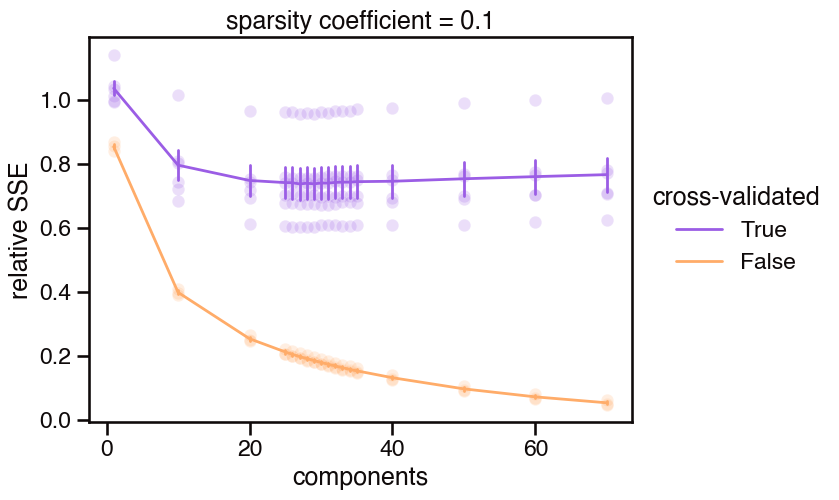

syn


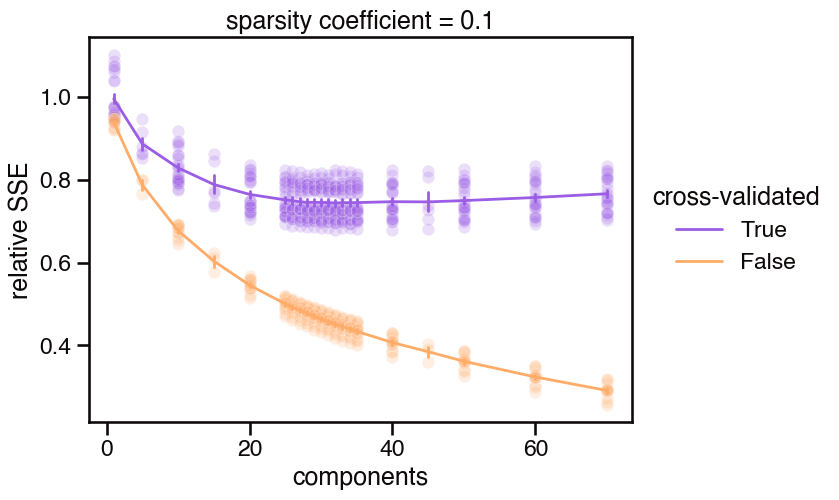

In [51]:
# cross val error vs. self error

lamb = .1

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['lambda'] == lamb]
    results_df['cross-validated'] = (results_df['modeled_replicate'] != results_df['comparison_replicate'])

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, boolean in enumerate([True, False]):
        data_df = results_df[results_df['cross-validated'] == boolean]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=boolean, 
            legend=False
        );
        sns.scatterplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            alpha=0.2, 
            data=data_df, 
            ax=axis, 
            legend=False
        );
    plt.title('sparsity coefficient = {}'.format(lamb));
    plt.xlabel('components')
    plt.ylabel('relative SSE')
    plt.legend(title='cross-validated', loc='center left', bbox_to_anchor=(1, .5));
    plt.savefig('{}-cv-effect-on-sse-lambda={}.png'.format(genus, lamb), bbox_inches='tight')
    plt.show()


pro


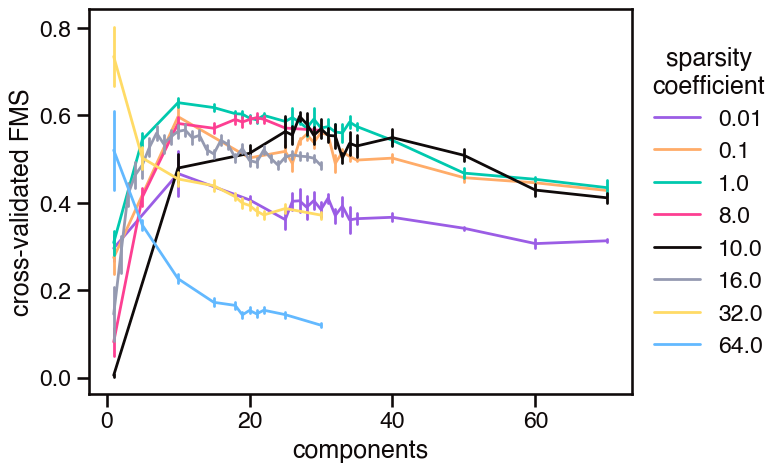

syn


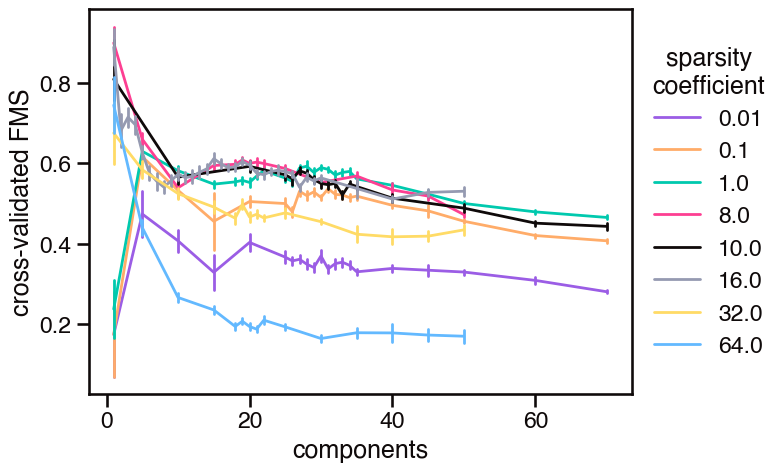

In [56]:
# look at fms vs rank

plot_lambdas = [0.01, 0.1, 1., 8., 10., 16., 32., 64.]

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['fms_cv'].notna()]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, lamb in enumerate(plot_lambdas):
        data_df = results_df[results_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='fms_cv', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=lamb
        );
#         sns.scatterplot(
#             x='rank', 
#             y='fms_cv', 
#             style='replicate_pair',
#             color=sns.color_palette()[i], 
#             alpha=0.2, 
#             data=data_df, 
#             ax=axis, 
#             legend=False
#         );
    plt.xlabel('components')
    plt.ylabel('cross-validated FMS')
    plt.legend(title='\t sparsity\ncoefficient', alignment='center', loc='center left', bbox_to_anchor=(1, .5));
    # plt.savefig('../figures/fms-v-rank-by-lambda.png', bbox_inches='tight')
    plt.show()


# sparsity fine tuning

pro


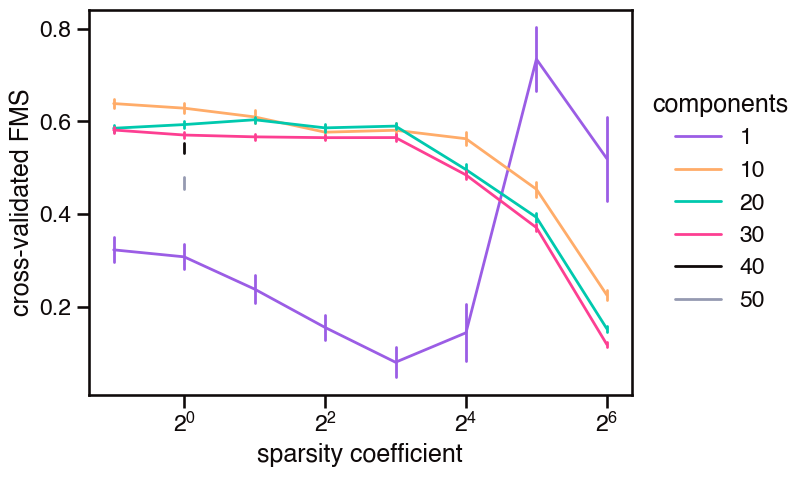

syn


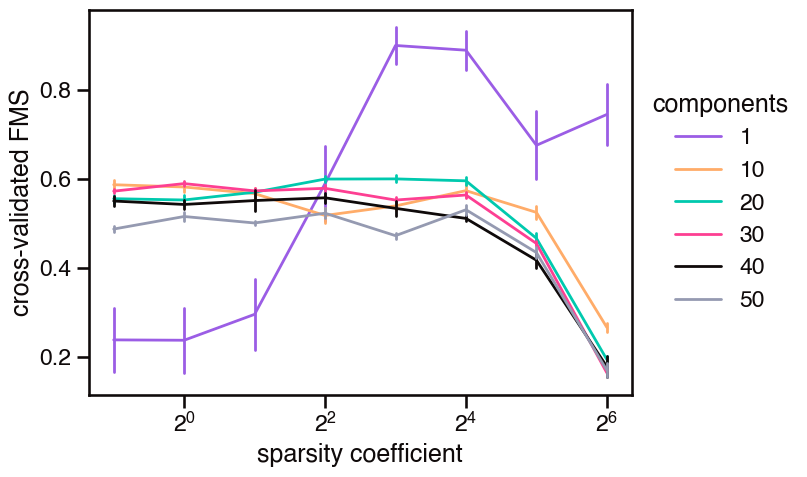

In [238]:
# look at finer-grained sparsity patterns just with the rank=30 models

results_df = combo_df[combo_df['rank'].isin([1, 10, 20, 30, 40, 50])]
results_df = results_df[results_df['lambda'].isin([0.5, 1., 2., 4., 8., 16., 32., 64.])]

for genus in ['pro', 'syn']:
    print(genus)
    working_df = results_df[results_df['genus'] == genus]
    working_df = working_df[working_df['modeled_replicate'] != working_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(working_df['rank'].unique()):
        data_df = working_df[working_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='fms_cv', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
    #     sns.scatterplot(
    #         x='lambda', 
    #         y='fms_cv', 
    #         style='replicate_pair',
    #         color=sns.color_palette()[i], 
    #         alpha=0.2, 
    #         data=data_df, 
    #         ax=axis, 
    #         legend=(i==len(subsets)-1)
    #     );
    plt.xscale('log', base=2);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('cross-validated FMS')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig('{}-fms-v-lambda-fine-tune.png'.format(genus), bbox_inches='tight')
    plt.show()
